# Lineage Tracking for Cells in the Mother Machine

In [5]:
%load_ext heat

The heat extension is already loaded. To reload it, use:
  %reload_ext heat


Looking for data at these locations:
.\example\csv\2022_04_22_PC_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_RFP_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_YFP_data_epoch_20_prob_99.csv
Finished loading the data
(11859, 11)

                    The average time interval for division is 26.5
                    The time constant for exponential growth is 23.897124717454066
                    The average division length is 45.45711299351284 with variance 42.96257431213435
                    


Tracking over frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.78it/s]
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)



                    The average time interval for division is 19.8
                    The time constant for exponential growth is 20.46461679235564
                    The average division length is 41.055515365600584 with variance 92.55175585263859
                    The length for adder model is 17.48338165283203 with variance 106.2973419241715
                    


Tracking over frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [15:03<00:00, 15.06s/it]
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\pyheat\pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


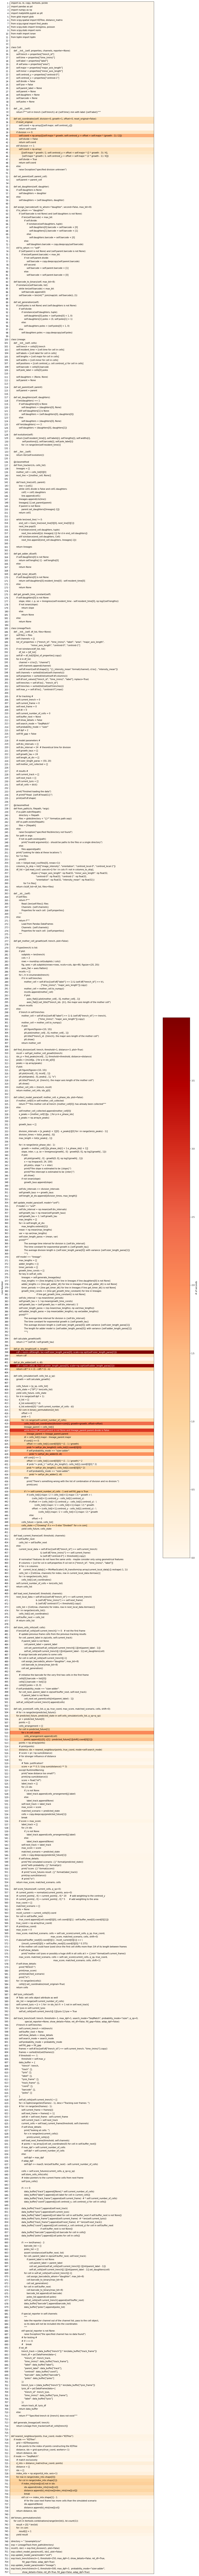

In [8]:
%%heat
import os, re, copy, itertools, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.spatial import KDTree, distance_matrix
from scipy.signal import find_peaks
from scipy.stats import linregress, poisson
from scipy.stats import norm
from math import isnan
from tqdm import tqdm


class Cell:
    def __init__(self, properties, channels, reporter=None):
        self.trench = properties["trench_id"]
        self.time = properties["time_(mins)"]
        self.label = properties["label"]
        # self.area = properties["area"]
        self.major = properties["major_axis_length"]
        self.minor = properties["minor_axis_length"]
        self.centroid_y = properties["centroid-0"]
        self.centroid_x = properties["centroid-1"]
        self.divide = False
        self.lyse = False
        self.parent_label = None
        self.parent = None
        self.daughters = None
        self.barcode = None
        self.poles = None

    def __str__(self):
        return f"""cell in trench {self.trench} at {self.time} min with label {self.label}"""

    def set_coordinates(self, division=0, growth=1, offset=0, reset_original=False):
        if reset_original:
            self.coord = np.array([[self.major, self.centroid_y]])
            return self.coord
        if division == 0:
            self.coord = np.array([[self.major * growth, self.centroid_y + offset + self.major * (growth - 1) / 2]])
            self.divide = False
            return self.coord
        elif division == 1:
            self.coord = np.array(
                [[self.major * growth / 2, self.centroid_y + offset + self.major * (2 * growth - 3) / 4],
                 [self.major * growth / 2, self.centroid_y + offset + self.major * (2 * growth - 1) / 4]])
            self.divide = True
            return self.coord
        else:
            raise Exception("specified division unknown")

    def set_parent(self, parent_cell):
        self.parent = parent_cell

    def set_daughters(self, daughter):
        if self.daughters is None:
            self.daughters = daughter
        else:
            self.daughters = (self.daughters, daughter)

    def assign_barcode(self, to_whom="daughter", second=False, max_bit=8):
        if to_whom == "daughter":
            if (self.barcode is not None) and (self.daughters is not None):
                if len(self.barcode) < max_bit:
                    if self.divide:
                        if isinstance(self.daughters, tuple):
                            self.daughters[0].barcode = self.barcode + [0]
                            self.daughters[1].barcode = self.barcode + [1]
                        else:
                            self.daughters.barcode = self.barcode + [0]
                    else:
                        self.daughters.barcode = copy.deepcopy(self.barcode)
        elif to_whom == "self":
            if (self.parent is not None) and (self.parent.barcode is not None):
                if len(self.parent.barcode) < max_bit:
                    if not self.parent.divide:
                        self.barcode = copy.deepcopy(self.parent.barcode)
                    elif second:
                        self.barcode = self.parent.barcode + [1]
                    else:
                        self.barcode = self.parent.barcode + [0]

    def barcode_to_binary(self, max_bit=8):
        if isinstance(self.barcode, list):
            while len(self.barcode) < max_bit:
                self.barcode.append(0)
            self.barcode = bin(int("".join(map(str, self.barcode)), 2))

    def set_generation(self):
        if (self.poles is not None) and (self.daughters is not None):
            if self.divide:
                if isinstance(self.daughters, tuple):
                    self.daughters[0].poles = (self.poles[0] + 1, 0)
                    self.daughters[1].poles = (0, self.poles[1] + 1)
                else:
                    self.daughters.poles = (self.poles[0] + 1, 0)
            else:
                self.daughters.poles = copy.deepcopy(self.poles)

class Lineage:
    def __init__(self, cells):
        self.trench = cells[0].trench
        self.resident_time = [cell.time for cell in cells]
        self.labels = [cell.label for cell in cells]
        self.lengths = [cell.major for cell in cells]
        self.widths = [cell.minor for cell in cells]
        self.positions = [(cell.centroid_x, cell.centroid_y) for cell in cells]
        self.barcode = cells[0].barcode
        self.pole_label = cells[0].poles

        self.daughters = (None, None)
        self.parent = None

    def set_parent(self, parent):
        self.parent = parent

    def set_daughters(self, daughters):
        if len(daughters) == 1:
            if self.daughters[0] is None:
                self.daughters = (daughters[0], None)
            elif self.daughters[1] is None:
                self.daughters = (self.daughters[0], daughters[0])
            else:
                self.daughters = (daughters[0], None)
        elif len(daughters) == 2:
            self.daughters = (daughters[0], daughters[1])

    def evolution(self):
        return [(self.resident_time[i], self.labels[i], self.lengths[i], self.widths[i],
                 self.positions[i], self.barcode[i], self.pole_label[i])
                for i in range(len(self.resident_time))]

    def __iter__(self):
        return iter(self.evolution())

    @classmethod
    def from_tracker(cls, cells_list):
        lineages = []
        mother_cell = cells_list[0][0]
        next_line = [(mother_cell, None)]

        def track_line(cell1, parent):
            line = [cell1]
            while cell1.divide is False and cell1.daughters:
                cell1 = cell1.daughters
                line.append(cell1)
            lineages.append(cls(line))
            lineages[-1].set_parent(parent)
            if parent is not None:
                parent.set_daughters([lineages[-1]])
            return cell1

        while len(next_line) != 0:
            end_cell = track_line(next_line[0][0], next_line[0][1])
            next_line.pop(0)
            if isinstance(end_cell.daughters, tuple):
                next_line.extend([(d, lineages[-1]) for d in end_cell.daughters])
            elif isinstance(end_cell.daughters, Cell):
                next_line.append((end_cell.daughters, lineages[-1]))

        return lineages

    def get_adder_dl(self):
        if self.daughters[0] is not None:
            return self.lengths[-1] - self.lengths[0]
        else:
            return None

    def get_timer_dt(self):
        if self.daughters[0] is not None:
            return self.daughters[0].resident_time[0] - self.resident_time[0]
        else:
            return None

    def get_growth_time_constant(self):
        if self.daughters[0] is not None:
            slope, inter, r, p, se = linregress(self.resident_time - self.resident_time[0], np.log2(self.lengths))
            if not isnan(slope):
                return slope
            else:
                return None
        else:
            return None

class LineageTrack:
    def __init__(self, df_list, files=None):
        self.files = files
        self.channels = []
        list_of_properties = ["trench_id", "time_(mins)", "label", "area", "major_axis_length",
                              "minor_axis_length", "centroid-0", "centroid-1"]
        if not isinstance(df_list, list):
            df_list = [df_list]
        self.df = df_list[0][list_of_properties].copy()
        for d in df_list:
            channel = d.loc[1, "channel"]
            self.channels.append(channel)
            self.df.insert(self.df.shape[1], "{}_intensity_mean".format(channel), d.loc[:, "intensity_mean"])
        self.channels = sorted(list(set(self.channels)))
        self.properties = sorted(list(set(self.df.columns)))
        self.df.sort_values(["trench_id", "time_(mins)", "label"], inplace=True)
        self.trenches = self.df.loc[:, "trench_id"]
        self.trenches = sorted(list(set(self.trenches)))
        self.max_y = self.df.loc[:, "centroid-0"].max()

        # for tracking #
        self.current_trench = 0
        self.current_frame = 0
        self.next_frame = 0
        self.dt = 0
        self.current_number_of_cells = 0
        self.buffer_next = None
        self.show_details = False
        self.search_mode = "SeqMatch"
        self.probability_mode = "sizer"
        self.dpf = 2
        self.fill_gap = False

        # model parameters #
        self.div_intervals = []
        self.div_interval = 24  # theoretical time for division
        self.growth_taus = []
        self.growth_tau = 24
        self.length_at_div = []
        self.sizer_length_paras = (50, 20)
        self.mother_cell_collected = []

        # results #
        self.current_track = []
        self.next_track = []
        self.current_lysis = []
        self.all_cells = dict()

        print("Finished loading the data")
        # print(f"Head: {self.df.head(1)}")
        print(self.df.shape)

    @classmethod
    def from_path(cls, filepath, *args):
        if os.path.isdir(filepath):
            directory = filepath
            files = glob(directory + "{}*".format(os.path.sep))
        elif os.path.exists(filepath):
            files = [filepath]
        else:
            raise Exception("specified file/directory not found")
        for path in args:
            if not os.path.exists(path):
                print("invalid argument(s) - should be paths to the files or a single directory")
            else:
                files.append(path)
        print("Looking for data at these locations:")
        for f in files:
            print(f)
        cols = list(pd.read_csv(files[0], nrows=1))
        columns_to_skip = list(["image_intensity", "orientation", "centroid_local-0", "centroid_local-1"])
        df_list = [pd.read_csv(f, usecols=[i for i in cols if i not in columns_to_skip],
                               dtype={"major_axis_length": np.float32, "minor_axis_length": np.float32,
                                      "centroid-0": np.float32, "centroid-1": np.float32,
                                      "orientation": np.float32, "intensity_mean": np.float32})
                   for f in files]
        return cls(df_list=df_list, files=files)

    def __str__(self):
        if self.files:
            return f"""
                Read {len(self.files)} files
                Channels: {self.channels}
                Properties for each cell: {self.properties}
            """
        else:
            return f"""
                Load from Pandas DataFrames
                Channels: {self.channels}
                Properties for each cell: {self.properties}
            """

    def get_mother_cell_growth(self, trench, plot=False):

        if type(trench) is list:
            if plot:
                subplots = len(trench)
                cols = 2
                rows = round(np.ceil(subplots / cols))
                fig, axes = plt.subplots(nrows=rows, ncols=cols, dpi=80, figsize=(20, 20))
                axes_flat = axes.flatten()
            mcells = []
            for i, tr in enumerate(trench):
                if tr in self.trenches:
                    mother_cell = self.df.loc[(self.df["label"] == 1) & (self.df["trench_id"] == tr),
                                              ["time_(mins)", "major_axis_length"]].copy()
                    mother_cell = mother_cell.to_numpy()
                    mcells.append(mother_cell)
                    if plot:
                        axes_flat[i].plot(mother_cell[:, 0], mother_cell[:, 1])
                        axes_flat[i].set_title(f"trench_ids: {tr}, the major axis length of the mother cell")
            return mcells
        else:
            if trench in self.trenches:
                mother_cell = self.df.loc[(self.df["label"] == 1) & (self.df["trench_id"] == trench),
                                          ["time_(mins)", "major_axis_length"]].copy()
                mother_cell = mother_cell.to_numpy()
                if plot:
                    plt.figure(figsize=(10, 10))
                    plt.plot(mother_cell[:, 0], mother_cell[:, 1])
                    plt.title(f"trench_id: {trench}, the major axis length of the mother cell")
                    plt.show()
                return mother_cell

    def find_division(self, trench, threshold=1, distance=3, plot=True):
        mcell = self.get_mother_cell_growth(trench)
        idx_p = find_peaks(mcell[:, 1], threshold=threshold, distance=distance)
        peaks = [mcell[p, :] for p in idx_p[0]]
        peaks = np.array(peaks)
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(mcell[:, 0], mcell[:, 1])
            plt.plot(peaks[:, 0], peaks[:, 1], "o")
            plt.title(f"trench_id: {trench}, the major axis length of the mother cell")
            plt.show()
        mother_cell_info = (trench, mcell)
        return mother_cell_info, idx_p[0]

    def collect_model_para(self, mother_cell, e_phase_idx, plot=False):
        if mother_cell[0] in self.mother_cell_collected:
            return f"""this mother cell at trench {mother_cell[0]} has already been collected"""
        else:
            self.mother_cell_collected.append(mother_cell[0])
            e_peaks = [mother_cell[1][p, :] for p in e_phase_idx]
            e_peaks = np.array(e_peaks)

            growth_taus = []

            division_intervals = [e_peaks[i + 1][0] - e_peaks[i][0] for i in range(len(e_peaks) - 1)]
            division_times = list(e_peaks[:, 0])
            max_length = list(e_peaks[:, 1])

            for i in range(len(e_phase_idx) - 1):
                growth = mother_cell[1][e_phase_idx[i] + 1:e_phase_idx[i + 1]]
                slope, inter, r, p, se = linregress(growth[:, 0] - growth[0, 0], np.log2(growth[:, 1]))
                if plot:
                    plt.plot(growth[:, 0] - growth[0, 0], np.log2(growth[:, 1]))
                    x = np.linspace(0, 24, 100)
                    plt.plot(x, slope * x + inter)
                    print(f"the slope is estimated to be {slope}")
                    print(f"the intercept is estimated to be {inter}")
                    plt.show()
                if not isnan(slope):
                    growth_taus.append(slope)

            self.div_intervals += division_intervals
            self.growth_taus += growth_taus
            self.length_at_div.append([division_times, max_length])

    def update_model_para(self, model="unif"):
        if model == "unif":
            self.div_interval = np.mean(self.div_intervals)
            self.growth_tau = np.mean(self.growth_taus)
            self.growth_tau = 1 / self.growth_tau
            max_lengths = []
            for i in self.length_at_div:
                max_lengths.extend(i[1])
            mean = np.mean(max_lengths)
            var = np.var(max_lengths)
            self.sizer_length_paras = (mean, var)
            print(f"""
                    The average time interval for division is {self.div_interval}
                    The time constant for exponential growth is {self.growth_tau}
                    The average division length is {self.sizer_length_paras[0]} with variance {self.sizer_length_paras[1]}
                    """)
        elif model == "lineage":
            max_lengths = []
            adder_lengths = []
            timer_periods = []
            growth_time_consts = []
            for key in self.all_cells:
                lineages = self.generate_lineage(key)
                max_lengths += [line.lengths[-1] for line in lineages if line.daughters[0] is not None]
                adder_lengths += [line.get_adder_dl() for line in lineages if line.get_adder_dl() is not None]
                timer_periods += [line.get_timer_dt() for line in lineages if line.get_timer_dt() is not None]
                growth_time_consts += [line.get_growth_time_constant() for line in lineages
                                       if line.get_growth_time_constant() is not None]
            self.div_interval = np.mean(timer_periods)
            self.growth_tau = 1 / np.mean(growth_time_consts)
            self.growth_tau = (self.growth_tau + self.div_interval) / 2
            self.sizer_length_paras = (np.mean(max_lengths), np.var(max_lengths))
            self.adder_length_paras = (np.mean(adder_lengths), np.var(adder_lengths))
            print(f"""
                    The average time interval for division is {self.div_interval}
                    The time constant for exponential growth is {self.growth_tau}
                    The average division length is {self.sizer_length_paras[0]} with variance {self.sizer_length_paras[1]}
                    The length for adder model is {self.adder_length_paras[0]} with variance {self.adder_length_paras[1]}
                    """)

    def calculate_growth(self):
        return 2 ** (self.dt / self.growth_tau)

    def pr_div_length(self, n, length):
        cdf = norm.cdf(length, loc=self.sizer_length_paras[0], scale=np.sqrt(self.sizer_length_paras[1]))
        return cdf

    def pr_div_adder(self, n, dl):
        cdf = norm.cdf(dl, loc=self.adder_length_paras[0], scale=np.sqrt(self.adder_length_paras[1]))
        return cdf * n + (1 - cdf) * (1 - n)

    def cells_simulator(self, cells_list, p_sp):
        growth = self.calculate_growth()

        cells_future = [p_sp, cells_list]
        cells_state = ["SP"] * len(cells_list)
        yield cells_future, cells_state
        for d in range(self.dpf + 1):
            d_list = []
            d_list.extend([1] * d)
            d_list.extend([0] * (self.current_number_of_cells - d))
            for com in binary_permutations(d_list):
                offset = 0
                prob = 1
                for i in range(self.current_number_of_cells):
                    cells_list[i].set_coordinates(division=com[i], growth=growth, offset=offset)
                    lineage_parent = cells_list[i]
                    while lineage_parent.parent is not None and lineage_parent.parent.divide is False:
                        lineage_parent = lineage_parent.parent
                    dl = cells_list[i].major - lineage_parent.major
                    if com[i] == 0:
                        offset += cells_list[i].coord[0][0] * (1 - 1 / growth)
                        prob *= self.pr_div_length(0, cells_list[i].coord[0][0])
                        if self.probability_mode == "sizer-adder":
                            prob *= self.pr_div_adder(0, dl)
                    elif com[i] == 1:
                        offset += cells_list[i].coord[0][0] * (1 - 1 / growth) * 2
                        # prob *= prob_1 * self.pr_div_length(1, cells_list[i].coord[0][0] * 2)
                        prob *= self.pr_div_length(1, cells_list[i].coord[0][0] * 2)
                        if self.probability_mode == "sizer-adder":
                            prob *= self.pr_div_adder(1, dl)
                    else:
                        print("There's something wrong with the list of combination of division and no division:")
                        print(com)

                    if i != self.current_number_of_cells - 1 and self.fill_gap is True:
                        if (cells_list[i].major / 2 + cells_list[i+1].major / 2) * growth > \
                                (cells_list[i+1].centroid_y - cells_list[i].centroid_y):
                            if offset >= (cells_list[i+1].centroid_y - cells_list[i].centroid_y) - \
                                    (cells_list[i].major / 2 + cells_list[i+1].major / 2) * growth:
                                offset -= (cells_list[i+1].centroid_y - cells_list[i].centroid_y) - \
                                          (cells_list[i].major / 2 + cells_list[i+1].major / 2) * growth
                            else:
                                offset = 0
                cells_future = [prob, cells_list]
                cells_state = ["Growing" if x == 0 else "Divided!" for x in com]
                yield cells_future, cells_state

    def load_current_frame(self, threshold, channels):
        if self.buffer_next:
            cells_list = self.buffer_next
        else:
            current_local_data = self.df.loc[(self.df["trench_id"] == self.current_trench)
                                             & (self.df["time_(mins)"] == self.current_frame)
                                             & (self.df["centroid-0"] < threshold)].copy()
            # normalise? features do not have the same units - maybe consider only using geometrical features
            # columns = [col for col in self.properties if col not in ["trench_id", "time_(mins)", "label"]]
            # for c in columns:
            #    current_local_data[c] = MinMaxScaler().fit_transform(np.array(current_local_data[c]).reshape(-1, 1))
            cells_list = [Cell(row, channels) for index, row in current_local_data.iterrows()]
            for i in range(len(cells_list)):
                cells_list[i].set_coordinates()
        self.current_number_of_cells = len(cells_list)
        return cells_list

    def load_next_frame(self, threshold, channels):
        next_local_data = self.df.loc[(self.df["trench_id"] == self.current_trench)
                                      & (self.df["time_(mins)"] == self.next_frame)
                                      & (self.df["centroid-0"] < threshold)].copy()
        cells_list = [Cell(row, channels) for index, row in next_local_data.iterrows()]
        for i in range(len(cells_list)):
            cells_list[i].set_coordinates()
        self.buffer_next = cells_list
        # return cells_list
    
    def store_cells_info(self, cells):
        if len(self.all_cells[self.current_trench]) != 0:  # not the first frame
            # update previous frame cells from the previous tracking results
            for cell, parent_label in zip(cells, self.current_track):
                if parent_label is not None:
                    cell.parent_label = parent_label
                    cell.set_parent(self.all_cells[self.current_trench][-1][int(parent_label - 1)])
                    self.all_cells[self.current_trench][-1][int(parent_label - 1)].set_daughters(cell)
            # assign barcode and poles to some cells
            for cell in self.all_cells[self.current_trench][-1]:
                cell.assign_barcode(to_whom="daughter", max_bit=8)
                cell.barcode_to_binary(max_bit=8)
                cell.set_generation()
        else:
            # initialise the barcode for the very first two cells in the first frame
            cells[0].barcode = list([0])
            cells[1].barcode = list([1])
            cells[0].poles = (0, 0)
        if self.probability_mode == "sizer-adder":
            for cell_next, parent_label in zip(self.buffer_next, self.next_track):
                if parent_label is not None:
                    cell_next.set_parent(cells[int(parent_label) - 1])
        self.all_cells[self.current_trench].append(cells)

    def calc_score(self, cells_list, p_sp, true_coord, max_score, matched_scenario, cells, shift=0):
        # for i in range(len(predicted_future)):
        for predicted_future, predicted_state in self.cells_simulator(cells_list, p_sp=p_sp):
            pr = predicted_future[0]
            points = []
            cells_arrangement = []
            for cell in predicted_future[1]:
                for c in cell.coord:
                    cells_arrangement.append(cell)
                    points.append([c[0], c[1] - predicted_future[1][shift].coord[0][1]])
            points = np.array(points)
            # print(points)
            distance, idx = nearest_neighbour(points, true_coord, mode=self.search_mode)
            # score = pr / np.sum(distance)
            # for stronger influence of distance
            try:
                # Todo: justification?
                score = pr ** 0.3 / ((np.sum(distance)) ** 3)
            except RuntimeWarning:
                print("wow distance too small?")
                print((np.sum(distance)))
                score = float("inf")
                label_track = []
                for j in idx:
                    if j is not None:
                        label_track.append(cells_arrangement[j].label)
                    else:
                        label_track.append(None)
                self.next_track = label_track
                max_score = score
                matched_scenario = predicted_state
                cells = copy.deepcopy(predicted_future[1])
                break
            if score > max_score:
                label_track = []
                for j in idx:
                    if j is not None:
                        label_track.append(cells_arrangement[j].label)
                    else:
                        label_track.append(None)
                self.next_track = label_track
                max_score = score
                matched_scenario = predicted_state
                cells = copy.deepcopy(predicted_future[1])
            if self.show_details:
                print("the simulated scenario: {}".format(predicted_state))
                print("with probability: {}".format(pr))
                print("score: {}".format(score))
                # print("score_futures result: {}".format(label_track))
                print(np.sum(distance))
                # print("\n")
        return max_score, matched_scenario, cells

    def score_futures(self, current_cells, p_sp=0):
        # current_points = normalize(current_points, axis=0)
        # current_points[:, 4] = current_points[:, 4] * 20     # add weighting to the centroid_y
        # current_points[:, 0] = current_points[:, 0] * 5      # add weighting to the area
        true_coord = []
        matched_scenario = []
        cells = None
        mcell_current = current_cells[0].coord
        for cell in self.buffer_next:
            true_coord.append([cell.coord[0][0], cell.coord[0][1] - self.buffer_next[0].coord[0][1]])
        true_coord = np.array(true_coord)
        # print(true_coord)
        max_score = 0
        max_score, matched_scenario, cells = self.calc_score(current_cells, p_sp, true_coord,
                                                             max_score, matched_scenario, cells, shift=0)
        if abs(self.buffer_next[0].coord[0][1] - mcell_current[0][1]) >= \
                ((mcell_current[0][0] + self.buffer_next[0].coord[0][0]) * 0.375):
            # the mother cell could have lysed since the first cell shifts more than 3/4 of its length between frames
            if self.show_details:
                print("mother cell lyses or possibly a huge shift in all cells at t = {}min".format(self.current_frame))
            max_score, matched_scenario, cells = self.calc_score(current_cells, p_sp, true_coord,
                                                                 max_score, matched_scenario, cells, shift=1)
        if self.show_details:
            print("RESULT:")
            print(max_score)
            print(matched_scenario)
            print("\n")
        for i in range(len(cells)):
            cells[i].set_coordinates(reset_original=True)
        return cells

    def lysis_cells(self):
        # Todo: set cells object attribute as well
        idx_list = range(self.current_number_of_cells)
        self.current_lysis = [i + 1 for i in idx_list if i + 1 not in self.next_track]
        for lysis in self.current_lysis:
            self.all_cells[self.current_trench][-1][lysis-1].lyse = True

    def track_trench(self, trench, threshold=-1, max_dpf=1, search_mode="SeqMatch", probability_mode="sizer", p_sp=0,
                     special_reporter=None, show_details=False, ret_df=False, fill_gap=False, adap_dpf=False):
        if trench in self.trenches:
            self.current_trench = int(trench)
            self.buffer_next = None
            self.show_details = show_details
            self.search_mode = search_mode
            self.probability_mode = probability_mode
            self.fill_gap = fill_gap
            frames = self.df.loc[self.df["trench_id"] == self.current_trench, "time_(mins)"].copy()
            frames = sorted(list(set(frames)))
            if threshold == -1:
                threshold = self.max_y
            data_buffer = {
                "trench": trench,
                "track": [],
                "lysis": [],
                "label": [],
                "lysis_frame": [],
                "track_frame": [],
                "coord": [],
                "barcode": [],
                "poles": []
            }
            self.all_cells[self.current_trench] = []
            for i in tqdm(range(len(frames) - 1), desc="Tracking over frames: "):
            # for i in range(len(frames) - 1):
                self.current_frame = frames[i]
                self.next_frame = frames[i + 1]
                self.dt = self.next_frame - self.current_frame
                self.current_track = self.next_track
                current_cells = self.load_current_frame(threshold, self.channels)
                if self.show_details:
                    print("looking at cells: ")
                    for x in range(len(current_cells)):
                        print(current_cells[x])
                self.load_next_frame(threshold, self.channels)
                # points = np.array([cell.set_coordinates(0) for cell in self.buffer_next])
                if max_dpf > self.current_number_of_cells:
                    self.dpf = self.current_number_of_cells
                else:
                    self.dpf = max_dpf
                if adap_dpf:
                    self.dpf += max(0, len(self.buffer_next) - self.current_number_of_cells)

                cells = self.score_futures(current_cells, p_sp=p_sp)
                self.store_cells_info(cells)
                # index pointers to the current frame cells from next frame
                self.lysis_cells()

                if i == 0:
                    data_buffer["track"].append([None] * self.current_number_of_cells)
                    data_buffer["label"].append([cell.label for cell in current_cells])
                    data_buffer["track_frame"].append(self.current_frame)  # * self.current_number_of_cells)
                    data_buffer["coord"].append([(cell.centroid_x, cell.centroid_y) for cell in cells])

                data_buffer["track"].append(self.next_track)
                data_buffer["lysis"].append(self.current_lysis)
                data_buffer["label"].append([cell.label for cell in self.buffer_next if self.buffer_next is not None])
                data_buffer["lysis_frame"].append(self.current_frame)  # * len(self.current_lysis))
                data_buffer["track_frame"].append(self.next_frame)  # * len(self.next_track))
                data_buffer["coord"].append([(cell.centroid_x, cell.centroid_y) for cell in self.buffer_next
                                             if self.buffer_next is not None])
                data_buffer["barcode"].append([cell.barcode for cell in cells])
                data_buffer["poles"].append([cell.poles for cell in cells])

                if i == len(frames) - 2:
                    barcode_list = []
                    poles_list = []
                    assert isinstance(self.buffer_next, list)
                    for cell, parent_label in zip(self.buffer_next, self.next_track):
                        if parent_label is not None:
                            cell.parent_label = parent_label
                            cell.set_parent(self.all_cells[self.current_trench][-1][int(parent_label - 1)])
                            self.all_cells[self.current_trench][-1][int(parent_label - 1)].set_daughters(cell)
                    for cell in self.all_cells[self.current_trench][-1]:
                        cell.assign_barcode(to_whom="daughter", max_bit=8)
                        cell.barcode_to_binary(max_bit=8)
                        cell.set_generation()
                    for cell in self.buffer_next:
                        cell.barcode_to_binary(max_bit=8)
                        barcode_list.append(cell.barcode)
                        poles_list.append(cell.poles)
                    self.all_cells[self.current_trench].append(self.buffer_next)
                    data_buffer["barcode"].append(barcode_list)
                    data_buffer["poles"].append(poles_list)

                if special_reporter in self.channels:
                    """
                    take the reporter channel out of the channel list, pass to the cell object, 
                    so its data will not be included into the coordinates
                    """
                elif special_reporter is not None:
                    raise Exception("the specified channel has no data found")
                # for testing #
                # if i == 0:
                #    break
            if ret_df:
                trench_track = [data_buffer["trench"]] * len(data_buffer["track_frame"])
                track_df = pd.DataFrame(data={
                    "trench_id": trench_track,
                    "time_(mins)": data_buffer["track_frame"],
                    "label": data_buffer["label"],
                    "parent_label": data_buffer["track"],
                    "centroid": data_buffer["coord"],
                    "barcode": data_buffer["barcode"],
                    "poles": data_buffer["poles"]
                })
                trench_lyse = [data_buffer["trench"]] * len(data_buffer["lysis_frame"])
                lysis_df = pd.DataFrame(data={
                    "trench_id": trench_lyse,
                    "time_(mins)": data_buffer["lysis_frame"],
                    "label": data_buffer["lysis"]
                })
                return track_df, lysis_df
            return data_buffer
        else:
            return f"""Specified trench id {trench} does not exist"""

    def generate_lineage(self, trench):
        return Lineage.from_tracker(self.all_cells[trench])


def nearest_neighbour(points, true_coord, mode="KDTree"):
    if mode == "KDTree":
        grid = KDTree(points)
        # idx points to the index of points constructing the KDTree
        distance, idx = grid.query(true_coord, workers=-1)
        return distance, idx
    if mode == "SeqMatch":
        # match exclusively
        d_mtx = distance_matrix(true_coord, points)
        distance = []
        idx = []
        index_mtx = np.argsort(d_mtx, axis=1)
        for row in range(index_mtx.shape[0]):
            for col in range(index_mtx.shape[1]):
                if index_mtx[row][col] not in idx:
                    idx.append(index_mtx[row][col])
                    distance.append(d_mtx[row][index_mtx[row][col]])
                    break
                elif col == index_mtx.shape[1] - 1:
                    # for the case next frame has more cells than the simulated scenario
                    idx.append(None)
                    distance.append(d_mtx[row][col])
        return distance, idx

def binary_permutations(lst):
    for com in itertools.combinations(range(len(lst)), lst.count(1)):
        result = [0] * len(lst)
        for i in com:
            result[i] = 1
        yield result

directory = ".\\example\\csv"    
exp = LineageTrack.from_path(directory)
mcell1, idx1 = exp.find_division(1, plot=False)
exp.collect_model_para(mcell1, idx1, plot=False)
exp.update_model_para(model="unif")
exp.track_trench(trench=1, threshold=250, max_dpf=3, show_details=False, ret_df=True, 
                 fill_gap=False, adap_dpf=True)
exp.update_model_para(model="lineage")
exp.track_trench(trench=1, threshold=500, max_dpf=3,  probability_mode="sizer-adder", 
                 show_details=False, ret_df=True, fill_gap=False, adap_dpf=True)